In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split

# to play the audio files
from IPython.display import Audio

from os.path import join as pjoin
import cv2
from PIL import Image

from typing import Dict, Any
import math
from copy import deepcopy

from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import torch
from torch import LongTensor, FloatTensor, HalfTensor, Tensor
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
import inspect

from catalyst import dl, utils
import timm

from torch.fft import fft, ifft

from torchaudio.functional import bandpass_biquad
from nnAudio.Spectrogram import CQT1992v2
import torchvision.models as models

%matplotlib inline

In [4]:
data_path = pd.read_csv("data_path.csv", #nrows=500
                       )


dict_of_class = {
    'neutral': 0,
    'sad': 1,
    'happy': 2,
    'angry': 3,
    'disgust': 4,
    'fear': 5,
    'surprise': 6,
    'calm': 0,
    }

data_path['target'] = data_path.apply(lambda x: dict_of_class[x.Emotions], axis=1)
dict_of_class.pop('calm')
n_of_class_emotion = len(dict_of_class)

In [5]:
train, test = train_test_split(data_path, test_size=0.2, stratify=data_path[['Emotions', 'dataset']].astype(str).apply('_'.join, axis=1), random_state=42)
train, valid = train_test_split(train, test_size=0.1, stratify=train[['Emotions', 'dataset']].astype(str).apply('_'.join, axis=1), random_state=42)
train.shape[0], valid.shape[0], test.shape[0]

(8756, 973, 2433)

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

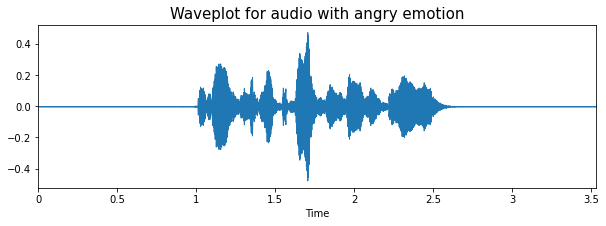

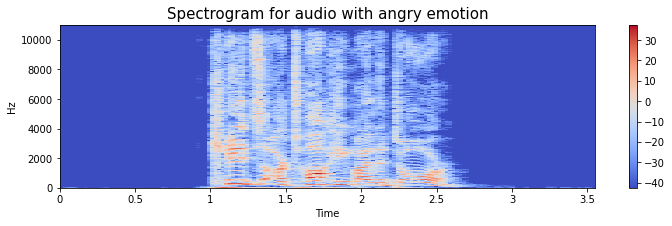

In [7]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
PERIOD=5

class Emotional_Dataset(Dataset):
    def __init__(self, path, target=None, idx=None, melspectrogram_parameters={}, img_size=224):
        self.path = np.array(path)
        if target is not None:
            self.target = FloatTensor(np.array(target))
        else:
            self.target = None
        self.index = idx
        self.melspectrogram_parameters = melspectrogram_parameters
        self.img_size = img_size
        
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        
        y, sampling_rate = librosa.load(self.path[idx], res_type='kaiser_fast')

        len_y = len(y)
        effective_length = sampling_rate * PERIOD

        if len_y < effective_length:
            new_y = np.zeros(effective_length, dtype=y.dtype)
            start = np.random.randint(effective_length - len_y)
            new_y[start:start + len_y] = y
            y = new_y.astype(np.float32)
        elif len_y > effective_length:
            start = np.random.randint(len_y - effective_length)
            y = y[start:start + effective_length].astype(np.float32)
        else:
            y = y.astype(np.float32)

        S = np.abs(librosa.stft(y, n_fft=1024));

        melspec = librosa.power_to_db(S**2, ref=np.max)

        #labels = np.zeros(n_of_class_emotion, dtype="f")
        #labels[int(self.target[idx])] = 1
        
        sample = {'features':  FloatTensor(np.expand_dims(melspec, 0))}
        if self.target is not None:
            sample['targets'] = int(self.target[idx])#labels.flatten()
            
        return sample

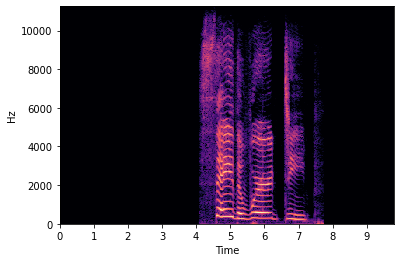

In [9]:
A_temp = Emotional_Dataset(train.Path, train.target)
smp = A_temp[0]
img, labl = smp['features'].numpy(), smp['targets']
#plt.imshow(img)#np.uint8(np.moveaxis(img, 0, 2)*255))
librosa.display.specshow(img[0], sr=22500, x_axis='time', y_axis='hz')   

In [10]:
class Preloaded_Emotional_Dataset(Dataset):
    def __init__(self, em_dataset):
        
        self.preloaded_spec = []
        for i in tqdm(range(len(em_dataset))):
            self.preloaded_spec.append(em_dataset[i])
            
    def __len__(self):
        return len(self.preloaded_spec)

    def __getitem__(self, idx):
        return self.preloaded_spec[idx]

In [11]:
class TimmModel(nn.Module):
    def __init__(self, name_of_model='tf_efficientnet_b0_ns', pretrained=True):
        super().__init__()

        self.img_model = timm.create_model(name_of_model, pretrained=pretrained, in_chans=1)
        self.classifier = nn.Sequential(nn.ELU(), nn.Dropout(0.2), nn.Linear(in_features=1000, out_features=n_of_class_emotion))

    def forward(self, features):
        
        return self.classifier(
            self.img_model(
                   features
            )
        )

In [12]:
!nvidia-smi

Fri Oct  1 10:51:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000001:00:00.0 Off |                    0 |
| N/A   25C    P0    41W / 250W |      4MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
EXP_PATH = 'New_dataset'


#for i, (fold_train, fold_val) in enumerate(cv_data):
#print('Fold', i)
#if i==0:
FOLD_PATH = f'{EXP_PATH}'

batch_size=60


loaders = {
    "train": DataLoader(Preloaded_Emotional_Dataset(Emotional_Dataset(train['Path'], train['target'])),
                        #worker_init_fn=worker_init_fn,
                        batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True),
    "valid": DataLoader(Preloaded_Emotional_Dataset(Emotional_Dataset(valid['Path'], valid['target'])), 
                        #worker_init_fn=worker_init_fn,
                        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4, pin_memory=True),
}

model =  TimmModel()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion =torch.nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=0, factor=0.3, min_lr=1e-8)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=3e-5)

callbacks = [
    #dl.AUCCallback(input_key="logits", target_key="targets",),
    dl.AccuracyCallback(
            input_key="logits", target_key="targets", num_classes=n_of_class_emotion
        ),
    dl.OptimizerCallback('loss'),
    dl.SchedulerCallback(loader_key='valid', metric_key='accuracy', mode='epoch'),
    dl.CheckpointCallback(loader_key='valid', metric_key='accuracy', minimize=False, save_n_best=3, mode='model', use_runner_logdir=True, use_logdir_postfix=True, ),
    dl.EarlyStoppingCallback(patience=4, loader_key="valid", metric_key="accuracy", minimize=False),
    dl.TimerCallback()
]
runner = dl.SupervisedRunner(input_key="features", target_key="targets", output_key="logits", loss_key="loss", )
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=100,#99999,#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    callbacks=callbacks,
    #engine=dl.DeviceEngine("cpu"),
    logdir=f"{FOLD_PATH}",
    valid_loader="valid",
    valid_metric="accuracy",
    minimize_valid_metric=False,
    verbose=True,
    load_best_on_end=True,
    amp=True,
)

  0%|          | 0/8756 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

1/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

train (1/100) accuracy: 0.2677011489868164 | accuracy/std: 0.08247663002186371 | accuracy01: 0.2677011489868164 | accuracy01/std: 0.08247663002186371 | accuracy03: 0.6214942932128906 | accuracy03/std: 0.10114714698726206 | accuracy05: 0.8673563599586487 | accuracy05/std: 0.07237177675979213 | loss: 1.806276798248291 | loss/mean: 1.806276798248291 | loss/std: 0.0985642514853047 | lr: 1e-05 | momentum: 0.9


1/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (1/100) accuracy: 0.3761562407016754 | accuracy/std: 0.06549222161929553 | accuracy01: 0.3761562407016754 | accuracy01/std: 0.06549222161929553 | accuracy03: 0.7327852249145508 | accuracy03/std: 0.0641278073291528 | accuracy05: 0.9455293416976929 | accuracy05/std: 0.03092734686859421 | loss: 1.6443239450454712 | loss/mean: 1.6443239450454712 | loss/std: 0.050391730692467676 | lr: 1e-05 | momentum: 0.9
* Epoch (1/100) lr: 1e-05 | momentum: 0.9


2/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (2/100) accuracy: 0.4008046090602875 | accuracy/std: 0.07004318061155976 | accuracy01: 0.4008046090602875 | accuracy01/std: 0.07004318061155976 | accuracy03: 0.7803448438644409 | accuracy03/std: 0.058518485182295986 | accuracy05: 0.9521839618682861 | accuracy05/std: 0.0290514507305724 | loss: 1.5720510482788086 | loss/mean: 1.5720510482788086 | loss/std: 0.07980801556694771 | lr: 1e-05 | momentum: 0.9


2/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (2/100) accuracy: 0.45118194818496704 | accuracy/std: 0.056884509176134544 | accuracy01: 0.45118194818496704 | accuracy01/std: 0.056884509176134544 | accuracy03: 0.8098664283752441 | accuracy03/std: 0.0481223911611961 | accuracy05: 0.9701952934265137 | accuracy05/std: 0.025235428825932493 | loss: 1.4668152332305908 | loss/mean: 1.4668152332305908 | loss/std: 0.06351591029830049 | lr: 1e-05 | momentum: 0.9
* Epoch (2/100) lr: 1e-05 | momentum: 0.9


3/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (3/100) accuracy: 0.479885071516037 | accuracy/std: 0.06800482655226095 | accuracy01: 0.479885071516037 | accuracy01/std: 0.06800482655226095 | accuracy03: 0.8341379761695862 | accuracy03/std: 0.04587982763713437 | accuracy05: 0.9688506126403809 | accuracy05/std: 0.02242656935006034 | loss: 1.4004203081130981 | loss/mean: 1.4004203081130981 | loss/std: 0.08070275471994404 | lr: 1e-05 | momentum: 0.9


3/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (3/100) accuracy: 0.5077081322669983 | accuracy/std: 0.05762878564331338 | accuracy01: 0.5077081322669983 | accuracy01/std: 0.05762878564331338 | accuracy03: 0.8365879058837891 | accuracy03/std: 0.04375696598750315 | accuracy05: 0.9794450402259827 | accuracy05/std: 0.023907540165495456 | loss: 1.3220070600509644 | loss/mean: 1.3220070600509644 | loss/std: 0.070112707148727 | lr: 1e-05 | momentum: 0.9
* Epoch (3/100) lr: 1e-05 | momentum: 0.9


4/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (4/100) accuracy: 0.5381609201431274 | accuracy/std: 0.06133977812188417 | accuracy01: 0.5381609201431274 | accuracy01/std: 0.06133977812188417 | accuracy03: 0.8673563599586487 | accuracy03/std: 0.04147322412722825 | accuracy05: 0.9773563742637634 | accuracy05/std: 0.02031251236686301 | loss: 1.2558352947235107 | loss/mean: 1.2558352947235107 | loss/std: 0.08212480071604393 | lr: 1e-05 | momentum: 0.9


4/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (4/100) accuracy: 0.5539568662643433 | accuracy/std: 0.06819114877850706 | accuracy01: 0.5539568662643433 | accuracy01/std: 0.06819114877850706 | accuracy03: 0.863309383392334 | accuracy03/std: 0.04651957842409721 | accuracy05: 0.9815005660057068 | accuracy05/std: 0.015505062746260331 | loss: 1.2099119424819946 | loss/mean: 1.2099119424819946 | loss/std: 0.08231458437162188 | lr: 1e-05 | momentum: 0.9
* Epoch (4/100) lr: 1e-05 | momentum: 0.9


5/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (5/100) accuracy: 0.5762069225311279 | accuracy/std: 0.060989809259232496 | accuracy01: 0.5762069225311279 | accuracy01/std: 0.060989809259232496 | accuracy03: 0.8801149725914001 | accuracy03/std: 0.04447892713101363 | accuracy05: 0.981724202632904 | accuracy05/std: 0.016762077188420498 | loss: 1.150060772895813 | loss/mean: 1.150060772895813 | loss/std: 0.09198806509603065 | lr: 1e-05 | momentum: 0.9


5/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (5/100) accuracy: 0.5930113196372986 | accuracy/std: 0.056220292574855044 | accuracy01: 0.5930113196372986 | accuracy01/std: 0.056220292574855044 | accuracy03: 0.8705036640167236 | accuracy03/std: 0.04440723663042317 | accuracy05: 0.9845837950706482 | accuracy05/std: 0.01250882010109499 | loss: 1.1366722583770752 | loss/mean: 1.1366722583770752 | loss/std: 0.0927785115387937 | lr: 1e-05 | momentum: 0.9
* Epoch (5/100) lr: 1e-05 | momentum: 0.9


6/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (6/100) accuracy: 0.6019540429115295 | accuracy/std: 0.06104502919746617 | accuracy01: 0.6019540429115295 | accuracy01/std: 0.06104502919746617 | accuracy03: 0.8960919976234436 | accuracy03/std: 0.0404979993346738 | accuracy05: 0.9841379523277283 | accuracy05/std: 0.01698991756271815 | loss: 1.0657832622528076 | loss/mean: 1.0657832622528076 | loss/std: 0.1031056887505509 | lr: 1e-05 | momentum: 0.9


6/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (6/100) accuracy: 0.5981500744819641 | accuracy/std: 0.047475067700728915 | accuracy01: 0.5981500744819641 | accuracy01/std: 0.047475067700728915 | accuracy03: 0.8859198689460754 | accuracy03/std: 0.03822764533718461 | accuracy05: 0.9825282692909241 | accuracy05/std: 0.01716277939897252 | loss: 1.0865663290023804 | loss/mean: 1.0865663290023804 | loss/std: 0.09650230624122237 | lr: 1e-05 | momentum: 0.9
* Epoch (6/100) lr: 1e-05 | momentum: 0.9


7/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (7/100) accuracy: 0.6282758712768555 | accuracy/std: 0.06838208599629736 | accuracy01: 0.6282758712768555 | accuracy01/std: 0.06838208599629736 | accuracy03: 0.9009195566177368 | accuracy03/std: 0.04480008983454537 | accuracy05: 0.985977053642273 | accuracy05/std: 0.015373112291263277 | loss: 1.001089334487915 | loss/mean: 1.001089334487915 | loss/std: 0.11162783561805521 | lr: 1e-05 | momentum: 0.9


7/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (7/100) accuracy: 0.606372058391571 | accuracy/std: 0.03956115592796058 | accuracy01: 0.606372058391571 | accuracy01/std: 0.03956115592796058 | accuracy03: 0.8941418528556824 | accuracy03/std: 0.034249723515725854 | accuracy05: 0.9876670241355896 | accuracy05/std: 0.013808544159733576 | loss: 1.0477710962295532 | loss/mean: 1.0477710962295532 | loss/std: 0.09517235318033582 | lr: 1e-05 | momentum: 0.9
* Epoch (7/100) lr: 1e-05 | momentum: 0.9


8/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (8/100) accuracy: 0.6431034803390503 | accuracy/std: 0.06671607120084368 | accuracy01: 0.6431034803390503 | accuracy01/std: 0.06671607120084368 | accuracy03: 0.9104598164558411 | accuracy03/std: 0.03890208893832749 | accuracy05: 0.9888505935668945 | accuracy05/std: 0.01356982026709643 | loss: 0.9495573043823242 | loss/mean: 0.9495573043823242 | loss/std: 0.09911029602676598 | lr: 1e-05 | momentum: 0.9


8/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (8/100) accuracy: 0.6104831099510193 | accuracy/std: 0.05058480723042979 | accuracy01: 0.6104831099510193 | accuracy01/std: 0.05058480723042979 | accuracy03: 0.8951696157455444 | accuracy03/std: 0.038050444127735734 | accuracy05: 0.9886947870254517 | accuracy05/std: 0.012788851145530118 | loss: 1.0234272480010986 | loss/mean: 1.0234272480010986 | loss/std: 0.1062695612082197 | lr: 1e-05 | momentum: 0.9
* Epoch (8/100) lr: 1e-05 | momentum: 0.9


9/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (9/100) accuracy: 0.6643678545951843 | accuracy/std: 0.06296443558217436 | accuracy01: 0.6643678545951843 | accuracy01/std: 0.06296443558217436 | accuracy03: 0.9202299118041992 | accuracy03/std: 0.03235445959192434 | accuracy05: 0.9895402789115906 | accuracy05/std: 0.013123323380127838 | loss: 0.9009566903114319 | loss/mean: 0.9009566903114319 | loss/std: 0.10572989965468149 | lr: 1e-05 | momentum: 0.9


9/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (9/100) accuracy: 0.633093535900116 | accuracy/std: 0.047160359250197424 | accuracy01: 0.633093535900116 | accuracy01/std: 0.047160359250197424 | accuracy03: 0.901336133480072 | accuracy03/std: 0.04208863288403139 | accuracy05: 0.9866392612457275 | accuracy05/std: 0.015810623379088045 | loss: 1.0050135850906372 | loss/mean: 1.0050135850906372 | loss/std: 0.1103181575254994 | lr: 1e-05 | momentum: 0.9
* Epoch (9/100) lr: 1e-05 | momentum: 0.9


10/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (10/100) accuracy: 0.6752874255180359 | accuracy/std: 0.059763605932589656 | accuracy01: 0.6752874255180359 | accuracy01/std: 0.059763605932589656 | accuracy03: 0.9287356734275818 | accuracy03/std: 0.031104312123120304 | accuracy05: 0.9914942979812622 | accuracy05/std: 0.011433804062048213 | loss: 0.8590357303619385 | loss/mean: 0.8590357303619385 | loss/std: 0.100584974365868 | lr: 1e-05 | momentum: 0.9


10/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (10/100) accuracy: 0.6372045874595642 | accuracy/std: 0.05963084422718646 | accuracy01: 0.6372045874595642 | accuracy01/std: 0.05963084422718646 | accuracy03: 0.9064748883247375 | accuracy03/std: 0.040140338910655625 | accuracy05: 0.9897225499153137 | accuracy05/std: 0.012985083574098518 | loss: 0.9861006140708923 | loss/mean: 0.9861006140708923 | loss/std: 0.10919418165868897 | lr: 1e-05 | momentum: 0.9
* Epoch (10/100) lr: 1e-05 | momentum: 0.9


11/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (11/100) accuracy: 0.6922988891601562 | accuracy/std: 0.058398913810046624 | accuracy01: 0.6922988891601562 | accuracy01/std: 0.058398913810046624 | accuracy03: 0.937471330165863 | accuracy03/std: 0.0329031752868478 | accuracy05: 0.9922989010810852 | accuracy05/std: 0.010361986028868973 | loss: 0.8175327777862549 | loss/mean: 0.8175327777862549 | loss/std: 0.10035235699694232 | lr: 1e-05 | momentum: 0.9


11/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (11/100) accuracy: 0.6320658326148987 | accuracy/std: 0.05806361119841998 | accuracy01: 0.6320658326148987 | accuracy01/std: 0.05806361119841998 | accuracy03: 0.8972250819206238 | accuracy03/std: 0.044857343292898706 | accuracy05: 0.9886947870254517 | accuracy05/std: 0.011369307248695022 | loss: 0.9845549464225769 | loss/mean: 0.9845549464225769 | loss/std: 0.1174203701481995 | lr: 1e-05 | momentum: 0.9
* Epoch (11/100) lr: 3e-06 | momentum: 0.9


12/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (12/100) accuracy: 0.7117241621017456 | accuracy/std: 0.0594105838136203 | accuracy01: 0.7117241621017456 | accuracy01/std: 0.0594105838136203 | accuracy03: 0.9463219046592712 | accuracy03/std: 0.028195595041248588 | accuracy05: 0.9935632348060608 | accuracy05/std: 0.008347836635716558 | loss: 0.7745010852813721 | loss/mean: 0.7745010852813721 | loss/std: 0.10039519890761996 | lr: 3e-06 | momentum: 0.9


12/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (12/100) accuracy: 0.6361768245697021 | accuracy/std: 0.05315481053344372 | accuracy01: 0.6361768245697021 | accuracy01/std: 0.05315481053344372 | accuracy03: 0.9044193625450134 | accuracy03/std: 0.03198395666817393 | accuracy05: 0.990750253200531 | accuracy05/std: 0.01309791533187742 | loss: 0.9731848835945129 | loss/mean: 0.9731848835945129 | loss/std: 0.11171275041886977 | lr: 3e-06 | momentum: 0.9
* Epoch (12/100) lr: 9e-07 | momentum: 0.9


13/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (13/100) accuracy: 0.7162069082260132 | accuracy/std: 0.06121557279439587 | accuracy01: 0.7162069082260132 | accuracy01/std: 0.06121557279439587 | accuracy03: 0.9437931180000305 | accuracy03/std: 0.0299406669078679 | accuracy05: 0.9941379427909851 | accuracy05/std: 0.010455925257019796 | loss: 0.7675003409385681 | loss/mean: 0.7675003409385681 | loss/std: 0.10621318349875407 | lr: 9e-07 | momentum: 0.9


13/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (13/100) accuracy: 0.6392600536346436 | accuracy/std: 0.05306139440662176 | accuracy01: 0.6392600536346436 | accuracy01/std: 0.05306139440662176 | accuracy03: 0.9023638367652893 | accuracy03/std: 0.03426521767306178 | accuracy05: 0.9907503128051758 | accuracy05/std: 0.011715877665915336 | loss: 0.9746345281600952 | loss/mean: 0.9746345281600952 | loss/std: 0.11190153579242369 | lr: 9e-07 | momentum: 0.9
* Epoch (13/100) lr: 9e-07 | momentum: 0.9


14/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (14/100) accuracy: 0.7195402979850769 | accuracy/std: 0.05876925913469001 | accuracy01: 0.7195402979850769 | accuracy01/std: 0.05876925913469001 | accuracy03: 0.9466667175292969 | accuracy03/std: 0.02758635571472239 | accuracy05: 0.9944827556610107 | accuracy05/std: 0.00919302992141061 | loss: 0.7540726661682129 | loss/mean: 0.7540726661682129 | loss/std: 0.1025228365440457 | lr: 9e-07 | momentum: 0.9


14/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (14/100) accuracy: 0.6361768245697021 | accuracy/std: 0.05505628651313784 | accuracy01: 0.6361768245697021 | accuracy01/std: 0.05505628651313784 | accuracy03: 0.90030837059021 | accuracy03/std: 0.03484102322738315 | accuracy05: 0.9886947870254517 | accuracy05/std: 0.012788851145530113 | loss: 0.9752206206321716 | loss/mean: 0.9752206206321716 | loss/std: 0.11395948619246803 | lr: 9e-07 | momentum: 0.9
* Epoch (14/100) lr: 2.6999999999999996e-07 | momentum: 0.9


15/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (15/100) accuracy: 0.7242529392242432 | accuracy/std: 0.051493368037504414 | accuracy01: 0.7242529392242432 | accuracy01/std: 0.051493368037504414 | accuracy03: 0.9479310512542725 | accuracy03/std: 0.03025499979063147 | accuracy05: 0.9942529201507568 | accuracy05/std: 0.011309474852895119 | loss: 0.749871015548706 | loss/mean: 0.749871015548706 | loss/std: 0.09949691611482982 | lr: 2.6999999999999996e-07 | momentum: 0.9


15/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (15/100) accuracy: 0.634121298789978 | accuracy/std: 0.04989960245479074 | accuracy01: 0.634121298789978 | accuracy01/std: 0.04989960245479074 | accuracy03: 0.9033915996551514 | accuracy03/std: 0.033417712314045216 | accuracy05: 0.9907503128051758 | accuracy05/std: 0.011715877665915336 | loss: 0.9768798351287842 | loss/mean: 0.9768798351287842 | loss/std: 0.11390296054310928 | lr: 2.6999999999999996e-07 | momentum: 0.9
* Epoch (15/100) lr: 8.099999999999998e-08 | momentum: 0.9


16/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (16/100) accuracy: 0.7293103933334351 | accuracy/std: 0.057046517287393225 | accuracy01: 0.7293103933334351 | accuracy01/std: 0.057046517287393225 | accuracy03: 0.9475862383842468 | accuracy03/std: 0.0287680767211171 | accuracy05: 0.9937931299209595 | accuracy05/std: 0.00957876097185352 | loss: 0.7512204647064209 | loss/mean: 0.7512204647064209 | loss/std: 0.0968054084026388 | lr: 8.099999999999998e-08 | momentum: 0.9


16/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (16/100) accuracy: 0.6413155794143677 | accuracy/std: 0.0531148436917815 | accuracy01: 0.6413155794143677 | accuracy01/std: 0.0531148436917815 | accuracy03: 0.9044193625450134 | accuracy03/std: 0.03355375626625157 | accuracy05: 0.9886947870254517 | accuracy05/std: 0.012788851145530114 | loss: 0.973841667175293 | loss/mean: 0.973841667175293 | loss/std: 0.11132098322950194 | lr: 8.099999999999998e-08 | momentum: 0.9
* Epoch (16/100) lr: 8.099999999999998e-08 | momentum: 0.9


17/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (17/100) accuracy: 0.7273563742637634 | accuracy/std: 0.05437787059004355 | accuracy01: 0.7273563742637634 | accuracy01/std: 0.05437787059004355 | accuracy03: 0.9466667175292969 | accuracy03/std: 0.030173657589779093 | accuracy05: 0.9942528605461121 | accuracy05/std: 0.010428089396276046 | loss: 0.745704710483551 | loss/mean: 0.745704710483551 | loss/std: 0.09690286045957963 | lr: 8.099999999999998e-08 | momentum: 0.9


17/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (17/100) accuracy: 0.6351490616798401 | accuracy/std: 0.05205957426224616 | accuracy01: 0.6351490616798401 | accuracy01/std: 0.05205957426224616 | accuracy03: 0.901336133480072 | accuracy03/std: 0.03456961087794491 | accuracy05: 0.9886947870254517 | accuracy05/std: 0.012788851145530113 | loss: 0.9753903746604919 | loss/mean: 0.9753903746604919 | loss/std: 0.11242348519577978 | lr: 8.099999999999998e-08 | momentum: 0.9
* Epoch (17/100) lr: 2.4299999999999996e-08 | momentum: 0.9


18/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (18/100) accuracy: 0.729425311088562 | accuracy/std: 0.05216006842005572 | accuracy01: 0.729425311088562 | accuracy01/std: 0.05216006842005572 | accuracy03: 0.9490805268287659 | accuracy03/std: 0.02474371933257912 | accuracy05: 0.9939080476760864 | accuracy05/std: 0.009751022009871137 | loss: 0.7490280270576477 | loss/mean: 0.7490280270576477 | loss/std: 0.08981870194270113 | lr: 2.4299999999999996e-08 | momentum: 0.9


18/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (18/100) accuracy: 0.6361768245697021 | accuracy/std: 0.056592077408573485 | accuracy01: 0.6361768245697021 | accuracy01/std: 0.056592077408573485 | accuracy03: 0.9054471254348755 | accuracy03/std: 0.03611533579954702 | accuracy05: 0.9907503128051758 | accuracy05/std: 0.011715877665915336 | loss: 0.9752557277679443 | loss/mean: 0.9752557277679443 | loss/std: 0.11162602337001763 | lr: 2.4299999999999996e-08 | momentum: 0.9
* Epoch (18/100) lr: 1e-08 | momentum: 0.9


19/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (19/100) accuracy: 0.7251724600791931 | accuracy/std: 0.05332624438846844 | accuracy01: 0.7251724600791931 | accuracy01/std: 0.05332624438846844 | accuracy03: 0.9471265077590942 | accuracy03/std: 0.02872578688483382 | accuracy05: 0.9949425458908081 | accuracy05/std: 0.007662857793934616 | loss: 0.7493337988853455 | loss/mean: 0.7493337988853455 | loss/std: 0.09599249071430294 | lr: 1e-08 | momentum: 0.9


19/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (19/100) accuracy: 0.6402878165245056 | accuracy/std: 0.05277417171642717 | accuracy01: 0.6402878165245056 | accuracy01/std: 0.05277417171642717 | accuracy03: 0.8992806077003479 | accuracy03/std: 0.042987260731254875 | accuracy05: 0.9907503128051758 | accuracy05/std: 0.011715877665915336 | loss: 0.9758267402648926 | loss/mean: 0.9758267402648926 | loss/std: 0.11366970622266932 | lr: 1e-08 | momentum: 0.9
* Epoch (19/100) lr: 1e-08 | momentum: 0.9


20/100 * Epoch (train):   0%|          | 0/145 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (20/100) accuracy: 0.7251724600791931 | accuracy/std: 0.05931353496972872 | accuracy01: 0.7251724600791931 | accuracy01/std: 0.05931353496972872 | accuracy03: 0.9460920095443726 | accuracy03/std: 0.030008994380702265 | accuracy05: 0.9941379427909851 | accuracy05/std: 0.01081619459954154 | loss: 0.7467108368873596 | loss/mean: 0.7467108368873596 | loss/std: 0.10657470161845443 | lr: 1e-08 | momentum: 0.9


20/100 * Epoch (valid):   0%|          | 0/17 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (20/100) accuracy: 0.6413155794143677 | accuracy/std: 0.05407464761276582 | accuracy01: 0.6413155794143677 | accuracy01/std: 0.05407464761276582 | accuracy03: 0.8992806077003479 | accuracy03/std: 0.039233435519926946 | accuracy05: 0.9907503128051758 | accuracy05/std: 0.011715877665915336 | loss: 0.9771501421928406 | loss/mean: 0.9771501421928406 | loss/std: 0.10902520058141596 | lr: 1e-08 | momentum: 0.9
* Epoch (20/100) lr: 1e-08 | momentum: 0.9
Top best models:
New_dataset/checkpoints/train.16.pth	0.6413
New_dataset/checkpoints/train.20.pth	0.6413
New_dataset/checkpoints/train.19.pth	0.6403


In [14]:
def predict_loader(model, loader):
    pred = runner.predict_loader(model=model, loader=loader)
    #pred = [torch.sigmoid(batch['logits'].detach().cpu().float()).numpy() for batch in tqdm(pred)] 
    pred = [batch['logits'].detach().cpu().float().numpy() for batch in tqdm(pred)] 
    pred = pd.Series(np.concatenate(pred, 0), index = loader.dataset.index)
    return pred


def write_prediction(pred, name, exp_path='logs'):
    sub = pd.read_csv('g2net-gravitational-wave-detection/sample_submission.csv').set_index('id')
    sub['target'] = pred
    sub.to_csv(f'{exp_path}/sub_{name}.csv')
    

    
def get_valid_logs(exp_path='logs'):
    valid_log = pd.read_csv(f'{exp_path}/logs/valid.csv')#.set_index('step')
    if ('step' == valid_log['step']).any():
        valid_log = valid_log.iloc[valid_log[valid_log['step'] == 'step'].index.max()+1:].reset_index(drop=True)
    return valid_log

In [15]:
test_dataloader = DataLoader(Emotional_Dataset(test['Path'], test['target']), 
                    #worker_init_fn=worker_init_fn,
                    batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4, pin_memory=False)
model =  TimmModel()
model.load_state_dict(torch.load(f'{EXP_PATH}/checkpoints/best.pth')['model_state_dict'])
model = model.eval().cuda()
score = get_valid_logs(EXP_PATH)['auc'].max()
#pred = predict_loader(model, test_dataloader)
#write_prediction(pred, f'best_{score}', EXP_PATH)

pred = runner.predict_loader(model=model, loader=test_dataloader)
#pred = [torch.sigmoid(batch['logits'].detach().cpu().float()).numpy() for batch in tqdm(pred)] 
pred = [batch['logits'].detach().cpu().float().numpy() for batch in tqdm(pred)] 


pred = pd.DataFrame(np.concatenate(pred, 0), index = test_dataloader.dataset.index)

test['pred'] = pred.apply(lambda row: row.argmax(), axis=1).values
from sklearn.metrics import accuracy_score
print(accuracy_score(test.target, test.pred))

0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0.6317303740238389


/tmp/ipykernel_30030/1812195194.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = pred.apply(lambda row: row.argmax(), axis=1).values


In [16]:
inv_class_dict = {}
for k in dict_of_class:
    inv_class_dict[dict_of_class[k]]=k

In [17]:
Personal = Emotional_Dataset(['personal/disgust_eng.wav'], [1])
smp = Personal[0]
img, labl = smp['features'].unsqueeze(0).to('cuda:0'), smp['targets']

inv_class_dict[int(model(img).argmax().cpu().data.numpy())]

'fear'